# RNN

In [1]:
# General requirements
import os
import pandas as pd
import numpy as np

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

# Set random state
import numpy as np
random_state = 47
np.random.seed(random_state)

# Use GPU (if available)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices( 'GPU' )
print( 'Num GPUs Available: ', len( physical_devices ) )
if len( physical_devices ) > 0:
    tf.config.experimental.set_memory_growth( physical_devices[0], True )

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  0


# 1. Data Preparation

## 1.1 Load Dataset

In [2]:
posenet_dataset_path = '../../datasets/posenet-uncut/'
kinect_dataset_path = '../../datasets/kinect_fixed_not_cut/'
cut_dataset_path = '../../datasets/new_posenet_marked_start_end/'
goodness_score = pd.read_csv('../../datasets/VideoScoring.csv')
exrecise_score = pd.read_csv('../../datasets/ExerciseScoring.csv')

train_test_ratio = 0.9
new_label = 'ExreciseScore'
exersice_score_indicator = 'O_Score'
goodness_score_indicator = 'AVG'
goodness_score_threshold = 3

In [3]:
# Drop video augmentation results
goodness_score = goodness_score[goodness_score['FileName'].str.match('U')==False]
goodness_score = goodness_score[goodness_score[goodness_score_indicator]>=goodness_score_threshold]

posenet_ok = goodness_score['FileName']+'.csv'

exrecise_score['Posenet'] = exrecise_score['Posenet'] + '.csv'
exrecise_score['Kinect'] = exrecise_score['Kinect'] + '.csv'

In [4]:
posenet_files = []
kinect_files = []

for file in os.listdir(posenet_dataset_path):
    if not file.find(".csv",0) == -1:
        if file in (goodness_score['FileName']+'.csv').to_list():
            posenet_files.append(file)
        
for file in os.listdir(kinect_dataset_path):
    if not file.find(".csv",0) == -1:
        if file in (goodness_score['FileName']+'_kinect.csv').to_list():
            kinect_files.append(file)
        
print('Total posenet datasets: {}'.format(len(posenet_files)))
print('Total kinect datasets: {}'.format(len(kinect_files)))

Total posenet datasets: 157
Total kinect datasets: 157


In [5]:
TRAIN_SPLIT_POSENET = int(len(posenet_files)*train_test_ratio)
TRAIN_SPLIT_KINECT = int(len(kinect_files)*train_test_ratio)
print(TRAIN_SPLIT_POSENET,TRAIN_SPLIT_KINECT)

141 141


## 1.2 Reshaping the datasets for RNN

In [6]:
def data_augmentation(df):
    augmented_datasets = []
    
    # Add original data
    augmented_datasets.append(df)
    
    # Mirror X coordinate
    for i in range(len(augmented_datasets)):
        augmented_datasets.append(mirror(augmented_datasets[i],'x', append=False))

    # Stretch by 50%
    for i in range(len(augmented_datasets)):
        df_temp = augMultiplier(augmented_datasets[i].drop(columns=[new_label]), multiplier=1.5)
        df_temp[new_label] = augmented_datasets[i][new_label]
        augmented_datasets.append(df_temp)
    

    # Compress by 25%
    for i in range(len(augmented_datasets)):
        df_temp = augMultiplier(augmented_datasets[i].drop(columns=[new_label]), multiplier=0.25)
        df_temp[new_label] = augmented_datasets[i][new_label]
        augmented_datasets.append(df_temp)
   

    # Rotate by p/7
#     samples = df.sample(5000)
#     angle = 3.1415 / 7
#     samples_rotated = rotate(samples.drop(columns=[new_label]), angle=angle, posenet=False)
#     samples_rotated[new_label] = samples[new_label].append(samples[new_label], ignore_index=True)
#     df = df.append(samples_rotated, ignore_index=True)
#     print(df.shape)

    # Rotate by -p/9
#     samples = df.sample(5000)
#     angle = 3.1415 / -9
#     samples_rotated = rotate(samples.drop(columns=[new_label]), angle=angle, posenet=False)
#     samples_rotated[new_label] = samples[new_label].append(samples[new_label], ignore_index=True)
#     df = df.append(samples_rotated, ignore_index=True)
#     print(df.shape)

    return augmented_datasets

In [7]:
HISTORY_SIZE = 30
STEP = 8
N_FEATURES = 39

def multivariate_data(dataset, target_column, history_columns):

    segments = []
    labels = []

    for i in range(0,len(dataset) - HISTORY_SIZE, STEP):
        segments.append(dataset[history_columns].values[i:i + HISTORY_SIZE])
        labels.append(dataset[target_column].mean())
    
    return np.array(segments), np.array(labels)

In [8]:
history_columns = [' head_x', 'head_y', 'head_z',
       'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_elbow_x',
       'left_elbow_y', 'left_elbow_z', 'right_shoulder_x', 'right_shoulder_y',
       'right_shoulder_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_hand_x', 'left_hand_y', 'left_hand_z', 'right_hand_x',
       'right_hand_y', 'right_hand_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_foot_x', 'left_foot_y',
       'left_foot_z', 'right_foot_x', 'right_foot_y', 'right_foot_z']
target_column = 'ExreciseScore'

def read_dataset(path,file_list,split_point,is_posenet=True,isTrain=True):
    all_segments = None
    all_labels = None
    
    start=0
    end=0
    
    if isTrain:
        start = 0
        end = split_point
    else:
        start = split_point
        end = len(file_list)
    
    for file in file_list[start:end]:
        df = pd.read_csv(path+file)
        
        if is_posenet:  
            df = df[df.columns.drop(list(df.filter(regex='_eye_')))]
            df = df[df.columns.drop(list(df.filter(regex='_ear_')))]
            df = df[df.columns.drop(list(df.filter(regex='score')))]
            df = df.rename(columns={'nose_x': 'head_x', 'nose_y': 'head_y'})
            df[new_label] = float(exrecise_score[exrecise_score['Posenet'] == file][exersice_score_indicator])
        else:  
            df = df.drop(columns=['Unnamed: 0','FrameNo'])
            df[new_label] = float(exrecise_score[exrecise_score['Kinect'] == file][exersice_score_indicator])
            
        # Cut start / end
        try:
            if not is_posenet:
                file = file.replace("_kinect","")
            se = pd.read_csv('../../datasets/new_posenet_marked_start_end/'+file)
            cut_start = min(se[(se['start']==0) * (se['end']==0)].index)
            cut_end = max(se[(se['start']==0) * (se['end']==0)].index)
            df = df.iloc[cut_start:cut_end]
        except IOError as e:
            print('Error in reading file: ', e)
            
    
        if isTrain:
            for sets in data_augmentation(df):
                segment,label = multivariate_data(sets,target_column,history_columns)

                if all_segments is None:
                    all_segments = segment
                    all_labels = label
                else:
                    all_segments = np.append(all_segments,segment,axis=0)  
                    all_labels = np.append(all_labels,label,axis=0)  

                sys.stdout.write("Total added rows: %d   \r" % (all_segments.shape[0]) )
                sys.stdout.flush()
        else:
            segment,label = multivariate_data(df,target_column,history_columns)

            if all_segments is None:
                all_segments = segment
                all_labels = label
            else:
                all_segments = np.append(all_segments,segment,axis=0)  
                all_labels = np.append(all_labels,label,axis=0)
    
    return all_segments,all_labels

In [9]:
X_train, y_train = read_dataset(kinect_dataset_path,kinect_files,TRAIN_SPLIT_KINECT,False,True)
X_test, y_test = read_dataset(kinect_dataset_path,kinect_files,TRAIN_SPLIT_KINECT,False,False)

Error in reading file:  [Errno 2] No such file or directory: '../../datasets/new_posenet_marked_start_end/A60.csv'


In [10]:
X_train.shape

(66744, 30, 39)

In [11]:
X_test.shape

(897, 30, 39)

## 1.3 Standardize features and labels

In [12]:
train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train-train_mean)/train_std
X_test = (X_test-train_mean)/train_std

target_mean = y_train.mean()
target_std = y_train.std()
y_train = (y_train-target_mean)/target_std
y_test = (y_test-target_mean)/target_std


print ('Train data shape')
print(X_train.shape)
print(y_train.shape)
print ('Test data shape')
print(X_test.shape)
print(y_test.shape)

Train data shape
(66744, 30, 39)
(66744,)
Test data shape
(897, 30, 39)
(897,)


In [13]:
BATCH_SIZE = 60
BUFFER_SIZE = 100000

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.batch(BATCH_SIZE).repeat()

# 2. Define Model Architecture

## 2.1 Model Architecture

In [14]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.layers import InputLayer

INPUT_SHAPE = X_train.shape[-2:]

metrics = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def create_model(layers, optimizer):
    model = tf.keras.models.Sequential(
        InputLayer(input_shape=INPUT_SHAPE)
    )

    for layer in layers:
        model.add(layer)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metrics)

    print(model.summary())

    return model

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

In [16]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_z"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_z"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_z"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_z"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_z"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "left_hand_z"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "right_hand_z"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_z"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_z"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_z"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_z"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "left_foot_z"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
    ColSpec("double", "right_foot_z"),
])
output_schema = Schema([
    ColSpec("double", "ExreciseScore"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

# 3. Run Experiments

In [19]:
from tensorflow.keras.layers import LSTM, Dense,GRU,Dropout

model_name = 'scoring_rnn_gru_kinect'

OPTIMIZER='adam'
EVALUATION_INTERVAL = 2000
EPOCHS = 50
VERBOSE = 1
ACTIVATION = 'relu'

lstm_model_1 = [
    GRU(32,return_sequences=True),
    GRU(8,activation=ACTIVATION),
    Dropout(0.2),
    Dense(32,activation=ACTIVATION),
    Dense(1)
]

tags = {"type.base": "RNN",
        "type.sub": "GRU",
        "domain": "exercise_score"}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 32)            7008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 1008      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,337
Trainable params: 8,337
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
2000/2000 [==============================] - 39s 18ms/step - loss: 0.6901 - mse: 0.6901 - mae: 0.6467 - 

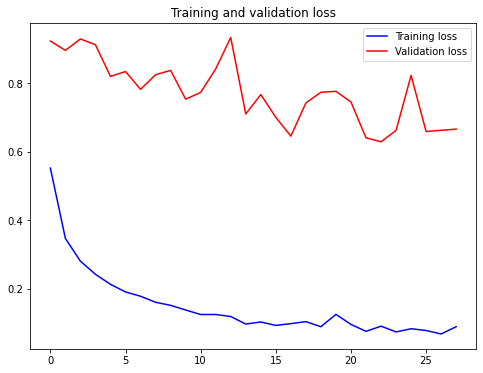

29/29 [==============================] - 0s 3ms/step


INFO:tensorflow:Assets written to: /var/folders/m8/zs0d09l904s28pmh_g_t5q640000gn/T/tmpfnm50s2y/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/zs0d09l904s28pmh_g_t5q640000gn/T/tmpfnm50s2y/model/data/model/assets


In [20]:
import time

with mlflow.start_run(run_name=model_name) as run:
    mlflow.set_tags(tags)

    model = create_model(layers=lstm_model_1, optimizer=OPTIMIZER)
    
    history = model.fit(train_set, 
                        epochs=EPOCHS, 
                        steps_per_epoch=EVALUATION_INTERVAL, 
                        validation_data=test_set, 
                        validation_steps=50,
                        verbose=VERBOSE, 
                        callbacks=[early_stopping])
    
    # Plot training history
    plot_train_history(history, 'Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()

    # Log model parameters
    mlflow.log_param("activation", ACTIVATION)
    mlflow.log_param("optimizer", OPTIMIZER)
    mlflow.log_param("evaluation interval", EVALUATION_INTERVAL)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
    mlflow.log_param("total params", model.count_params())
    mlflow.log_param("C", HISTORY_SIZE)
    mlflow.log_param("step size", STEP)
    mlflow.log_param("input mean", train_mean)
    mlflow.log_param("input std", train_std)
    mlflow.log_param("output mean", target_mean)
    mlflow.log_param("output std", target_std)

    # Log model prediction time
    predictions = None
    times = []
    for i in range(10):
        start_time = time.time()
        predictions = model.predict(X_test,verbose=1)
        end_time = time.time()
        process_time = (end_time - start_time) * 1000
        times.append(process_time)
    process_time = sum(times) / len(times) / len(predictions)

    # Log model performance
    predictions = predictions * target_std + target_mean
    actual = y_test * target_std + target_mean

    (mse, mae, r2, variance) = eval_metrics(actual, predictions)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_metric("process time", process_time)
    
    # Log model and scaler(s)
    mlflow.keras.log_model(model, model_name, signature=signature)
#     mlflow.sklearn.log_model(X_scaler, 'InputScaler')
#     mlflow.sklearn.log_model(y_scaler, 'OutputScaler')

## 3.2 Plot Training History

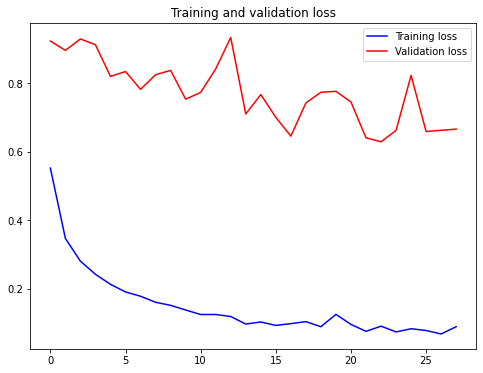

In [21]:
plot_train_history(history, 'Training and validation loss')
#plt.savefig("training_history.jpg")
#mlflow.log_artifact("training_history.jpg")
plt.show()

29/29 [==============================] - 0s 3ms/step


<AxesSubplot:>

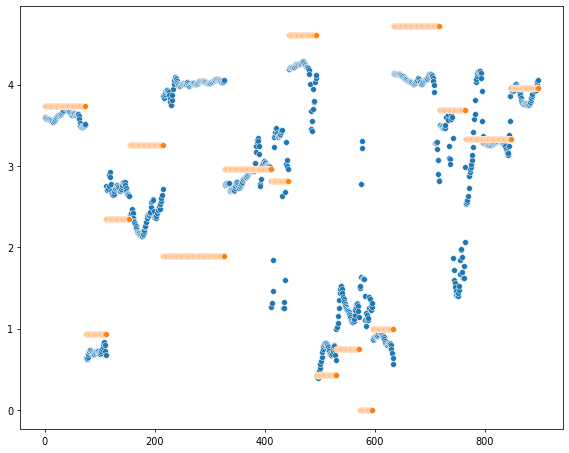

In [22]:
import seaborn
import matplotlib.pyplot as plt
import numpy
w = 10
h = 8
d = 70
plt.figure(figsize=(w, h), dpi=d)

a = model.predict(X_test,verbose=1).reshape(-1) * target_std + target_mean
b = y_test* target_std + target_mean

y1=y_test.reshape(len(predictions))
y2=predictions.reshape(len(predictions))
x = np.arange(len(y_test))

seaborn.scatterplot(x, a)
seaborn.scatterplot(x, b)
